In [316]:
import pandas as pd
import numpy as np
import PythonMagick
from PIL import Image
import re

%matplotlib inline



In [684]:
DOWNSCALED_WIDTH=400

def downscale(img):
    o_width, o_height = img.size
    height = round((DOWNSCALED_WIDTH/o_width) * o_height)
    
    ds_img = img.convert('L').resize((DOWNSCALED_WIDTH, height), resample=Image.BILINEAR)
    
    return ds_img

def pixels_df(img):
    pixels = list(img.getdata())
    width, height = img.size
    pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

    return pd.DataFrame(pixels)


In [685]:
original = Image.open("../input/test-8.jpg")

img = downscale(original)
df = pixels_df(img)

print("Shape of matrix is %dx%d" % (df.shape))


# 0 = white, 1 = black pixels
contrasted = df.applymap(lambda x: int(np.sqrt(x) if x < 127 else x**2) / (255**2))
contrasted.describe()

Shape of matrix is 283x400


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,...,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.000000,283.0,283.000000,283.0
mean,0.999889,0.998326,0.998013,0.998178,0.998782,0.998920,0.998354,0.998419,0.997365,0.997395,...,0.594158,0.585775,0.591433,0.590163,0.590144,0.779261,0.997457,1.0,0.999972,1.0
std,0.001135,0.012598,0.015093,0.014956,0.010535,0.010277,0.012885,0.014028,0.023500,0.027765,...,0.416840,0.418979,0.425908,0.427280,0.433142,0.248334,0.004468,0.0,0.000465,0.0
min,0.984375,0.813533,0.785483,0.785483,0.878447,0.849289,0.863806,0.792449,0.658962,0.555171,...,0.000123,0.000123,0.000123,0.000123,0.000138,0.305744,0.984375,1.0,0.992172,1.0
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000123,0.000131,0.000138,0.000138,0.000138,0.515017,0.992172,1.0,1.000000,1.0
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.710880,0.691180,0.730857,0.744329,0.771642,0.885813,1.000000,1.0,1.000000,1.0
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.968874,0.968874,0.976609,0.980492,0.984375,1.000000,1.000000,1.0,1.000000,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0


In [686]:
def rescale(serie):
    #return serie * 1/serie.max()
    serie -= serie.min()
    return serie / serie.max()

def middle(df, replacement):
    df2 = df.copy()
    
    if df.__class__ == pd.DataFrame:
        third = int(len(df.columns) / 3)

        df2.loc[:, :third] = replacement
        df2.loc[:, 2*third:] = replacement
    else:
        third = int(len(df) / 3)
        df2.loc[:third] = replacement
        df2.loc[2*third:] = replacement

    return df2

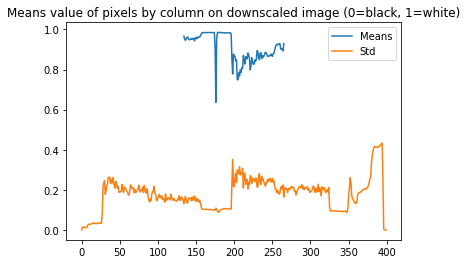

In [687]:
means = middle(contrasted, np.nan).mean()
means.plot(title="Means value of pixels by column on downscaled image (0=black, 1=white)", label="Means", legend=True)

std = contrasted.std()
std.plot(label="Std", legend=True)


In [688]:
img.show()

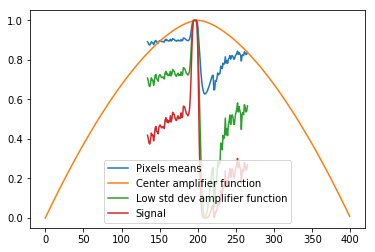

In [672]:
def apply_func_factory(serie):
    center = len(serie)/2

    def apply_func(x):
        idx = x.name
        return 1 - (abs(center - idx) ** 1.618) / center**1.618
    
    return apply_func
    

apply_func = apply_func_factory(means)

center_amplifier = means.reset_index().apply(apply_func, axis=1)

low_std_amplifier = rescale(means / (1 - means.std()))

means.plot(label="Pixels means", legend=True)
center_amplifier.plot(label="Center amplifier function", legend=True)
low_std_amplifier.plot(label="Low std dev amplifier function", legend=True)


signal = rescale(rescale(means) * center_amplifier * low_std_amplifier)

signal.plot(label="Signal", legend=True)

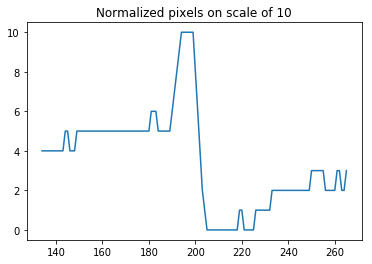

In [673]:
normalized = (signal * 10).round()
normalized.plot(title="Normalized pixels on scale of 10")

In [674]:
grouped = pd.DataFrame([normalized]).T.groupby(normalized, as_index=False)

# luminosity distinct sorted values (10 at max = whitest)
lum_val = grouped[0].last().round().values.flatten()
lum_val.sort()
whitest = lum_val[-1]
darkest = lum_val[0]

# whitests columns (maximum of luminosity)
white_cols = pd.Series(grouped.get_group(whitest).index)
dark_cols = pd.Series(grouped.get_group(darkest).index)

if len(white_cols) < 0.01 * DOWNSCALED_WIDTH and lum_val[-2] >= whitest - 1:
    next_group = pd.Series(grouped.get_group(lum_val[-2]).index)
    if len(next_group) < 0.02 * DOWNSCALED_WIDTH:
        white_cols = white_cols.append(next_group).sort_values()


In [675]:
first_idx, last_idx = white_cols.min(), white_cols.max()

white_band = normalized.loc[first_idx:last_idx]

if white_band.min() > white_band.max() - 2:
    print("Use margin because original band min=%i, max=%i" % (white_band.min(), white_band.max()))
    margin = max(1, round(0.01 * DOWNSCALED_WIDTH))
    white_band = normalized.loc[first_idx-margin:last_idx+margin]

print("White band between has index range %d-%d" % (white_band.index[0], white_band.index[-1]))
# we have a dark local minimum in the white band
band_min = white_band.min()
print("Darkest inside white band: %s" % band_min)

Use margin because original band min=10, max=10
White band between has index range 190-203
Darkest inside white band: 2.0


In [676]:
if whitest == 10 and (last_idx-first_idx+1) == len(white_cols) and len(white_cols) >= 0.02 * DOWNSCALED_WIDTH:
    binding_point = white_cols.median()
    print("binding_point=%f (strong white band)" % binding_point)
elif band_min <= whitest - 5:
    dark_inside_median = white_band[white_band == band_min].reset_index()['index']
        
    binding_point = dark_inside_median.median()
    print("binding_point=%f (local dark inside white band)" % binding_point)
elif darkest == 0 and len(dark_cols) <= 0.01 * DOWNSCALED_WIDTH:
    binding_point = dark_cols.median()
    print("binding_point=%f (dark peak)" % binding_point)
else:
    # binding as median of indexes
    binding_point = white_cols.median()
    print("binding_point=%f (brightness max (default))" % binding_point)


binding_point=203.000000 (local dark inside white band)


In [677]:
o_width, _ = original.size
cut_x = round(o_width * (binding_point / DOWNSCALED_WIDTH))
print("Split image must occurs at X=%d" % cut_x)

Split image must occurs at X=1199


In [678]:
regex = re.compile(r"\D+(?P<left>[0-9]+)(?:[-_](?P<right>[0-9]+))?\.jpg$")

def splitted_pages_numbers(filename):
    match = regex.search(filename)

    # page names as numbers
    # left = int(match.group('left'))
    # right = int(match.group('right') or left + 1)

    # page names as suffixed from original
    left = match.group('left') + "-a"
    right = match.group('right') or (match.group('left') + "-b")

    return { "left": left, "right": right }


In [679]:
def output_path(page_n):
    return "../output/page-%s.jpg" % page_n

def split_pages_paths(original_filename):
    pages_numbers = splitted_pages_numbers(original_filename)
    
    return {
        "left": output_path(pages_numbers["left"]),
        "right": output_path(pages_numbers["right"]),
    }
    
    
def horizontal_split(img, cut_x):
    dimLeft = (0, 0, cut_x - 1, img.height)
    print("Dimensions left=%s" % str(dimLeft))
    imgLeft = img.crop(dimLeft)
    
    dimRight = (cut_x, 0, img.width, img.height)
    print("Dimensions right=%s" % str(dimRight))
    imgRight = img.crop(dimRight)
    

    file_paths = split_pages_paths(img.filename)
    
    imgLeft.save(file_paths['left'])
    imgRight.save(file_paths['right'])
    
    print("Saved 2 images: %s" % str(file_paths))

horizontal_split(original, cut_x)

Dimensions left=(0, 0, 1198, 2185)
Dimensions right=(1199, 0, 2362, 2185)
Saved 2 images: {'left': '../output/page-001-a.jpg', 'right': '../output/page-001-b.jpg'}
